In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import glob
import numpy as np
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

In [2]:
def clean_column_ids(col):
    return col.str.split("|").str[1]

def read_scores(path):
    df= pd.read_csv(path,   delimiter=r"\s+", comment="#", usecols=[0,2, 4,5], header=None)
    df.columns = ["sequence", "reference", "e-value", "score"]
    df.sort_values(by=["score"], inplace=True, ascending=False)
    df["sequence"] = clean_column_ids(df["sequence"])
    df.set_index("sequence", inplace=True)
    return df

In [3]:
df_hmms = read_scores("./../out/uniprot_sprot.40.multi-step/hmmsearch/P69340.out")
df_hmms.rename(columns={"score" : "hmms_score", "e-value" : "hmms_e-value"}, inplace=True)
print(df_hmms.shape)
print(df_hmms.dtypes)
df_hmms.head()

(121, 3)
reference        object
hmms_e-value      int64
hmms_score      float64
dtype: object


,reference,hmms_e-value,hmms_score
sequence,,,
B7LV40,P69340,0,1986.6
Q323D9,P69340,0,1986.3
B5YUD4,P69340,0,1985.6
Q7ACM1,P69340,0,1985.6
A7ZNP9,P69340,0,1985.6


In [4]:
df_phmm = read_scores("./../out/uniprot_sprot.40.multi-step/phmmer/P69340.out")
df_phmm.rename(columns={"score" : "phmm_score", "e-value" : "phmm_e-value"}, inplace=True)
print(df_phmm.shape)
print(df_phmm.dtypes)
df_phmm.head()

(121, 3)
reference        object
phmm_e-value    float64
phmm_score      float64
dtype: object


,reference,phmm_e-value,phmm_score
sequence,,,
P69340,sp|P69340|MDTB_SHIFL,0.0,2214.9
A7ZNP8,sp|P69340|MDTB_SHIFL,0.0,2202.1
Q8X7J4,sp|P69340|MDTB_SHIFL,0.0,2201.2
A1ACT0,sp|P69340|MDTB_SHIFL,0.0,2200.3
B1LNW6,sp|P69340|MDTB_SHIFL,0.0,2200.3


In [5]:
df = pd.concat([df_phmm, df_hmms], axis=1)
print(df.shape)
df.head()

(121, 6)


,reference,phmm_e-value,phmm_score,reference,hmms_e-value,hmms_score
P69340,sp|P69340|MDTB_SHIFL,0.0,2214.9,P69340,0,1887.7
A7ZNP8,sp|P69340|MDTB_SHIFL,0.0,2202.1,P69340,0,1897.8
Q8X7J4,sp|P69340|MDTB_SHIFL,0.0,2201.2,P69340,0,1896.5
A1ACT0,sp|P69340|MDTB_SHIFL,0.0,2200.3,P69340,0,1897.6
B1LNW6,sp|P69340|MDTB_SHIFL,0.0,2200.3,P69340,0,1897.6


<AxesSubplot:xlabel='hmms_score', ylabel='phmm_score'>

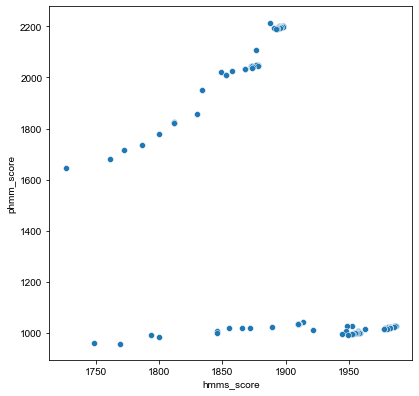

In [6]:
f, ax = plt.subplots(figsize=(6.5,6.5))
sb.set_theme(style="whitegrid")
#ax.set(yscale="log")
sb.scatterplot(ax=ax, x="hmms_score", y="phmm_score", data=df)

In [11]:
def load_scores(path):
    hmms_files = glob.glob(path.replace("$$$", "hmmsearch"))
    phmm_files = glob.glob(path.replace("$$$", "phmmer"))
    files = list(zip(hmms_files, phmm_files))
    dfs = []
    for filename in files:
        hmms_df = read_scores(filename[0])
        phmm_df = read_scores(filename[1])
        hmms_df.rename(columns={"score" : "hmms_score", "e-value" : "hmms_e-value"}, inplace=True)
        phmm_df.rename(columns={"score" : "phmm_score", "e-value" : "phmm_e-value"}, inplace=True)
        phmm_df.drop(["reference"], axis=1, inplace=True)
        df = pd.concat([phmm_df, hmms_df], axis=1)
        df["phmm_score"] = scaler.fit_transform(df["phmm_score"].values.reshape(-1,1))
        df["hmms_score"] = scaler.fit_transform(df["hmms_score"].values.reshape(-1,1))
        dfs.append(df)
    frame = pd.concat(dfs, axis=0)
    return frame

def plot_scores(frame):
    f, ax = plt.subplots(figsize=(6.5,6.5))
    sb.set_theme(style="whitegrid")
    #ax.set(yscale="log", xscale="log")
    sb.scatterplot(x="hmms_score", y="phmm_score", hue="reference", ax=ax, data=frame)
    #if ax.get_legend():
        #ax.get_legend().remove()

In [8]:
df = load_scores("./../out/uniprot_sprot.40.multi-step/$$$/*.out")
df.sample(10)

,phmm_e-value,phmm_score,reference,hmms_e-value,hmms_score
Q8UFY6,6.100000e-45,0.244382,Q36863,1.100000e-99,0.855172
B0S9I4,1.800000e-158,0.334928,P13375,3.100000e-200,0.565852
Q1GB31,1.500000e-47,0.268258,Q36863,2.700000e-95,0.756552
P23975,5.100000e-188,0.251875,Q03614,1.000000e-273,0.785858
Q8XKK1,2.000000e-55,0.340449,Q36863,1.800000e-102,0.917931
A6T6Q1,3.300000e-170,0.658402,Q83LU4,2.600000e-153,0.791902
B5YT10,1.600000e-35,0.305156,A4G9H5,2.600000e-61,0.997990
Q09FT6,1.300000e-42,0.223315,Q36863,8.600000e-85,0.520000
C1DCR4,1.500000e-53,0.549644,A4G712,3.600000e-61,0.829787
A1K783,1.800000e-53,0.322472,Q36863,4.300000e-104,0.954483


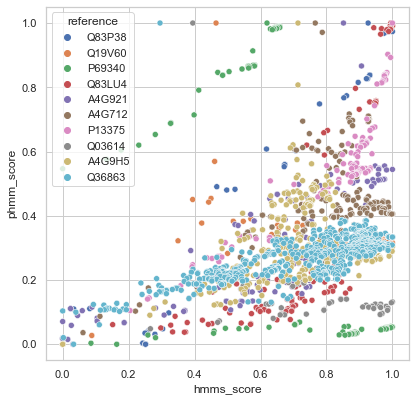

In [9]:
plot_scores(df)

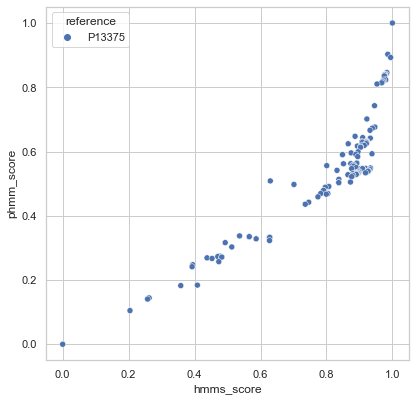

In [10]:
plot_scores(df[df["reference"]=="P13375"])

In [159]:
df = load_scores("./../out/uniprot_sprot.70.multi-step/$$$/*.out")

In [160]:
all = df.shape[0]
print(df[df["phmm_e-value"]==0].shape[0]/all)
print(df[df["hmms_e-value"]==0].shape[0]/all)


0.09657210401891253
0.14191919191919192


In [149]:
def plot_hist(data, col, bins):
    a = [data[data[col]==0].shape[0]]
    for bin in bins:
        a.append(data[data[col]<bin].shape[0]-np.cumsum(a)[-1])
    return a

In [150]:
d = plot_hist(df, "hmms_e-value", np.power(10,-np.linspace(200, 0, 11)).tolist())
